# 1st version: Restaurant Level with custom preprocessor 

Reviews are then aggregated by restaurant title so that all comments for the same restaurant are concatenated into a single document, producing 296 restaurant level samples from the original 53 566 review level rows.

## Load and Aggregate (The Setup)

After aggregation, the problem is framed as a multiclass text classification task where the input is the aggregated restaurant level raw_text and the target is the cuisine label categoryName. A single stratified train–test split with 80% of restaurants for training and 20% for testing is created, ensuring all models are evaluated on exactly the same 60 test restaurants and preserving the class distribution across the split.

In [1]:
import pandas as pd
import pipeline_v3 # Your custom utility file
from sklearn.model_selection import train_test_split

# 1. Load Data and Select Columns
# We need 'title' to group by restaurant, and 'stars' for later tasks
df = pd.read_csv(r'C:\Users\nhatp\OneDrive - NOVAIMS\Desktop\this semester\projects\text mining project\data_atlanta\atlanta_restaurant_slice_2023.csv')
df = df[['title', 'categoryName', 'text', 'stars']]
df = df.rename(columns={"text": "raw_text"})
df["raw_text"] = df["raw_text"].astype(str)

# 2. The "Ambition" Step: Aggregate reviews by Restaurant
# This converts 53,566 reviews into ~1,000 Restaurants
print(f"Rows before aggregation: {len(df)}")
df_grouped = pipeline_v3.aggregate_reviews(df, group_col='title', text_col='raw_text', label_col='categoryName')
print(f"Rows after aggregation (Unique Restaurants): {len(df_grouped)}")

# 3. Define X and y
X = df_grouped['raw_text']
y = df_grouped['categoryName']

# 4. Split Data (Stratify is crucial due to class imbalance)
# We split ONLY ONCE to ensure both models use exactly the same train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Rows before aggregation: 53566
Rows after aggregation (Unique Restaurants): 296


## Pipeline A - The Baseline (TF-IDF)

The baseline pipeline combines a custom TextPreprocessor based on NLTK with a TfidfVectorizer (1–2 grams, 5 000 features) and a class balanced logistic regression classifier. Generic words such as “food”, “place”, and “restaurant” are added to the stopword list to focus the model on more specific cuisine cues, and the resulting model achieves around 0.83 accuracy, with macro and weighted F1 scores close to 0.8 on the 19 cuisine classes

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("punkt_tab")

# 1. Build Pipeline
# Note: We add custom stopwords to remove generic words that don't help classify cuisine
pipeline_tfidf = Pipeline([
    ('preprocessor', pipeline_v3.TextPreprocessor(
        lowercase=True, 
        lemmatize=True,
        custom_stopwords=['food', 'place', 'restaurant', 'service', 'time', 'back', 'great', 'good']
    )),
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# 2. Train and Predict
print("Training Baseline (TF-IDF)...")
pipeline_tfidf.fit(X_train, y_train)
y_pred_tfidf = pipeline_tfidf.predict(X_test)

# 3. Evaluation
print("\n--- BASELINE REPORT (TF-IDF) ---")
print(classification_report(y_test, y_pred_tfidf))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nhatp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Training Baseline (TF-IDF)...

--- BASELINE REPORT (TF-IDF) ---
                          precision    recall  f1-score   support

     American restaurant       0.50      0.14      0.22         7
             Bar & grill       0.00      0.00      0.00         1
     Barbecue restaurant       0.50      1.00      0.67         1
    Breakfast restaurant       1.00      1.00      1.00         2
      Chicken restaurant       0.67      1.00      0.80         2
      Chinese restaurant       1.00      1.00      1.00         3
    Fast food restaurant       1.00      0.67      0.80         3
    Hamburger restaurant       0.67      1.00      0.80         2
       Indian restaurant       1.00      1.00      1.00         2
      Italian restaurant       1.00      1.00      1.00         6
     Japanese restaurant       1.00      1.00      1.00         2
Mediterranean restaurant       1.00      1.00      1.00         2
      Mexican restaurant       1.00      1.00      1.00        10
 New Americ

## Pipeline B - The Challenger (BERT Embeddings)

As a more ambitious model, this version encodes the same restaurant level texts using the pretrained SentenceTransformer all MiniLM L6 v2 to obtain dense semantic embeddings. A logistic regression with class weighting is trained on these embeddings and evaluated on the same test set, yielding roughly 0.67 accuracy and slightly lower macro and weighted F1 than the TF IDF baseline, while still performing strongly on some frequent and distinctive cuisines such as Mexican and Italian.

In [3]:
from sentence_transformers import SentenceTransformer

# 1. Load Pre-trained Model
# 'all-MiniLM-L6-v2' is designed for speed and performance
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Encode Data
# Note: We pass raw text. BERT handles context/grammar better than cleaned text.
print("Generating BERT Embeddings... (This takes a moment)")
X_train_bert = bert_model.encode(X_train.tolist(), show_progress_bar=True)
X_test_bert = bert_model.encode(X_test.tolist(), show_progress_bar=True)

# 3. Train Classifier on Embeddings
clf_bert = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_bert.fit(X_train_bert, y_train)

# 4. Predict
y_pred_bert = clf_bert.predict(X_test_bert)

# 5. Evaluation
print("\n--- CHALLENGER REPORT (BERT) ---")
print(classification_report(y_test, y_pred_bert))

c:\Users\nhatp\anaconda3\envs\text_mining\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating BERT Embeddings... (This takes a moment)


Batches: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


--- CHALLENGER REPORT (BERT) ---
                          precision    recall  f1-score   support

     American restaurant       1.00      0.14      0.25         7
             Bar & grill       0.00      0.00      0.00         1
     Barbecue restaurant       0.33      1.00      0.50         1
    Breakfast restaurant       0.33      0.50      0.40         2
      Chicken restaurant       0.40      1.00      0.57         2
      Chinese restaurant       0.75      1.00      0.86         3
    Fast food restaurant       0.25      0.33      0.29         3
    Hamburger restaurant       0.50      1.00      0.67         2
       Indian restaurant       1.00      1.00      1.00         2
      Italian restaurant       1.00      0.83      0.91         6
     Japanese restaurant       0.67      1.00      0.80         2
Mediterranean restaurant       1.00      0.50      0.67         2
      Mexican restaurant       0.90      0.90      0.90        10
 New American restaurant       0.00      

# 2nd version: Restaurant level with Scikit-Learn pipeline preprocessor and hyperparameter_tuned via grid search


The tuned no preprocessor model is strong and very close to 1st version, so it works well as a comparative scenario rather than a replacement.

## Pipeline A - The Baseline (TF-IDF)

•	The tuned TF IDF + LR model without custom pre processing reaches about 0.77 accuracy and macro F1 ≈ 0.79 on the restaurant level test set, with best CV macro F1 ≈ 0.69 using C=2.0, max_features=8000, min_df=1.

•	The 1st version with TextPreprocessor had accuracy around 0.83 and macro/weighted F1 ≈ 0.80–0.85, so it is slightly better overall, especially on frequent classes, which supports the argument that your custom cleaning and stopwords add value beyond plain TF IDF.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("punkt_tab")

# 1. Build Pipeline

# Simple search pipeline: no custom preprocessor, TF-IDF + LR only
search_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

param_grid = {
    "tfidf__max_features": [3000, 5000, 8000],
    "tfidf__min_df": [1, 2, 5],
    "clf__C": [0.5, 1.0, 2.0]
}

grid = GridSearchCV(
    estimator=search_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV for TF-IDF + LogisticRegression (no custom preprocessor)...")
grid.fit(X_train, y_train)

print("\nBest params:", grid.best_params_)
print("Best CV macro F1:", grid.best_score_)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nhatp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Running GridSearchCV for TF-IDF + LogisticRegression (no custom preprocessor)...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best params: {'clf__C': 2.0, 'tfidf__max_features': 8000, 'tfidf__min_df': 1}
Best CV macro F1: 0.689608386109934


In [5]:
from sklearn.metrics import classification_report

best_search = grid.best_estimator_
y_pred_search = best_search.predict(X_test)

print("\n=== TUNED NO-PREPROCESSOR MODEL ===")
print(classification_report(y_test, y_pred_search))


=== TUNED NO-PREPROCESSOR MODEL ===
                          precision    recall  f1-score   support

     American restaurant       0.00      0.00      0.00         7
             Bar & grill       0.00      0.00      0.00         1
     Barbecue restaurant       1.00      1.00      1.00         1
    Breakfast restaurant       1.00      1.00      1.00         2
      Chicken restaurant       0.50      1.00      0.67         2
      Chinese restaurant       1.00      1.00      1.00         3
    Fast food restaurant       1.00      0.67      0.80         3
    Hamburger restaurant       1.00      1.00      1.00         2
       Indian restaurant       1.00      1.00      1.00         2
      Italian restaurant       1.00      0.67      0.80         6
     Japanese restaurant       1.00      1.00      1.00         2
Mediterranean restaurant       1.00      1.00      1.00         2
      Mexican restaurant       1.00      0.90      0.95        10
 New American restaurant       1.00   

c:\Users\nhatp\anaconda3\envs\text_mining\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nhatp\anaconda3\envs\text_mining\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nhatp\anaconda3\envs\text_mining\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

## Pipeline B - The Challenger (BERT Embeddings)

In [6]:
from sentence_transformers import SentenceTransformer

# 1. Load Pre-trained Model
# 'all-MiniLM-L6-v2' is designed for speed and performance
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Encode Data
# Note: We pass raw text. BERT handles context/grammar better than cleaned text.
print("Generating BERT Embeddings... (This takes a moment)")
X_train_bert = bert_model.encode(X_train.tolist(), show_progress_bar=True)
X_test_bert = bert_model.encode(X_test.tolist(), show_progress_bar=True)

# 3. Train Classifier on Embeddings
clf_bert = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_bert.fit(X_train_bert, y_train)

# 4. Predict
y_pred_bert = clf_bert.predict(X_test_bert)

# 5. Evaluation
print("\n--- CHALLENGER REPORT (BERT) ---")
print(classification_report(y_test, y_pred_bert))

Generating BERT Embeddings... (This takes a moment)


Batches: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]


--- CHALLENGER REPORT (BERT) ---
                          precision    recall  f1-score   support

     American restaurant       1.00      0.14      0.25         7
             Bar & grill       0.00      0.00      0.00         1
     Barbecue restaurant       0.33      1.00      0.50         1
    Breakfast restaurant       0.33      0.50      0.40         2
      Chicken restaurant       0.40      1.00      0.57         2
      Chinese restaurant       0.75      1.00      0.86         3
    Fast food restaurant       0.25      0.33      0.29         3
    Hamburger restaurant       0.50      1.00      0.67         2
       Indian restaurant       1.00      1.00      1.00         2
      Italian restaurant       1.00      0.83      0.91         6
     Japanese restaurant       0.67      1.00      0.80         2
Mediterranean restaurant       1.00      0.50      0.67         2
      Mexican restaurant       0.90      0.90      0.90        10
 New American restaurant       0.00      

•	Present this tuned no preprocessor model as models in 2nd version, describing the search space and best hyperparameters, and highlight that its performance is competitive but slightly worse than Models in the 1st version.

•	Mention that some rare classes (“American restaurant”, “Bar & grill”) still have poor precision/recall due to very small support, which later address in the error analysis and confusion matrix discussion.

# 3rd Version: review level 

In this version each review has a single category; wrap it as a list to use MultiLabelBinarizer (multilabel one‑vs‑rest classifier)

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pipeline_v3

# 1. Load data
df = pd.read_csv(r"C:\Users\nhatp\OneDrive - NOVAIMS\Desktop\this semester\projects\text mining project\data_atlanta\atlanta_restaurant_slice_2023.csv")
df = df[['title', 'categoryName', 'text', 'stars']]
df = df.rename(columns={"text": "raw_text"})
df["raw_text"] = df["raw_text"].astype(str)

# 2. Build multilabel target at review level
# Here each review has a single category; wrap it as a list to use MultiLabelBinarizer
df["label_list"] = df["categoryName"].apply(lambda x: [x])

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["label_list"])
X = df["raw_text"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# 3. Multilabel TF-IDF + OneVsRest LR
pipeline_multilabel = Pipeline([
    ("preprocessor", pipeline_v3.TextPreprocessor(
        lowercase=True,
        lemmatize=True
    )),
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ("clf", OneVsRestClassifier(
        LogisticRegression(max_iter=1000, class_weight="balanced")
    ))
])

pipeline_multilabel.fit(X_train, Y_train)
Y_pred = pipeline_multilabel.predict(X_test)

print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))


                          precision    recall  f1-score   support

     American restaurant       0.24      0.65      0.35      1006
             Bar & grill       0.11      0.53      0.19       230
     Barbecue restaurant       0.21      0.67      0.32       225
    Breakfast restaurant       0.21      0.59      0.31       508
      Chicken restaurant       0.18      0.66      0.28       363
      Chinese restaurant       0.22      0.62      0.32       495
    Fast food restaurant       0.37      0.77      0.50      1058
    Hamburger restaurant       0.32      0.64      0.43       403
       Indian restaurant       0.30      0.70      0.42       330
      Italian restaurant       0.29      0.64      0.40      1006
     Japanese restaurant       0.20      0.61      0.30       302
Mediterranean restaurant       0.14      0.55      0.23       275
      Mexican restaurant       0.47      0.72      0.57      1776
 New American restaurant       0.16      0.55      0.25       375
        P

c:\Users\nhatp\anaconda3\envs\text_mining\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


• Micro and macro F1 around 0.38–0.41 mean the multilabel one‑vs‑rest classifier is much less accurate than the restaurant‑level TF‑IDF model (≈0.8 F1/accuracy), which is expected because each review is shorter and noisier than an aggregated restaurant profile.​

• Recall is high (≈0.63 macro, 0.66 micro) while precision is low (≈0.25 macro), which means the model tends to over‑predict labels, producing many false positives; the warning about some samples having no predicted labels confirms that the decision thresholds and calibration are not ideal.

• Keep this version as a methodological add‑on: it demonstrates that you tried a “true” multilabel one‑vs‑rest formulation at review level and quantitatively compared it to the main restaurant‑level multiclass setup, which fits the spirit of requirement 3311.​

• In the report, argue that the client‑facing model will use restaurant‑level aggregation because it yields much better performance and more stable per‑class metrics, while the review‑level multilabel attempt shows that short individual reviews carry less signal for accurate cuisine classification.​

# 4th version: Restaurant level with merged classes (class Framentation)

Looking at distribution, we have 60 samples total across 19 classes. That implies an average of ~3 samples per class. BERT is powerful, but it cannot generalize effectively on 1-3 examples (e.g., "Bar & grill" has 1 sample, "New American" has 3). The model is confused between semantically similar concepts (like Hamburger vs. Fast Food or American vs. New American). This strategy merges classes that share nearly identical vocabulary in customer reviews. This balances granularity with model stability

In [8]:
import pandas as pd
import pipeline_v3 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sentence_transformers import SentenceTransformer

# ==========================================
# 1. DEFINE THE MERGE FUNCTION
# ==========================================
def merge_cuisines(label):
    # Group 1: American / Grill / Steak / Seafood / Breakfast
    if label in ['American restaurant', 'New American restaurant', 'Bar & grill', 
                 'Barbecue restaurant', 'Steak house', 'Seafood restaurant', 'Breakfast restaurant']:
        return 'American/Grill'
    
    # Group 2: Fast Food / Casual / Sandwiches
    elif label in ['Fast food restaurant', 'Hamburger restaurant', 
                   'Chicken restaurant', 'Sandwich shop']:
        return 'Fast Food/Casual'
    
    # Group 3: Italian / European / Pizza
    elif label in ['Italian restaurant', 'Pizza restaurant', 'Mediterranean restaurant']:
        return 'Italian/Mediterranean'
    
    # Group 4: Asian (East + South)
    elif label in ['Chinese restaurant', 'Japanese restaurant', 'Thai restaurant', 'Indian restaurant']:
        return 'Asian'
    
    # Group 5: Mexican (Distinct enough to keep, usually)
    elif label == 'Mexican restaurant':
        return 'Mexican'
        
    # Catch-all for anything else not listed
    else:
        return 'Other'

# ==========================================
# 2. LOAD & PREPARE DATA
# ==========================================
df = pd.read_csv(r'C:\Users\nhatp\OneDrive - NOVAIMS\Desktop\this semester\projects\text mining project\data_atlanta\atlanta_restaurant_slice_2023.csv')
df = df[['title', 'categoryName', 'text', 'stars']]
df = df.rename(columns={"text": "raw_text"})
df["raw_text"] = df["raw_text"].astype(str)

# Aggregate reviews by Restaurant
print(f"Rows before aggregation: {len(df)}")
df_grouped = pipeline_v3.aggregate_reviews(df, group_col='title', text_col='raw_text', label_col='categoryName')
print(f"Rows after aggregation: {len(df_grouped)}")



Rows before aggregation: 53566
Rows after aggregation: 296


In [9]:
# --- CRITICAL CHANGE HERE ---
# Apply the merging function to create a new label column
df_grouped['merged_label'] = df_grouped['categoryName'].apply(merge_cuisines)

# Check the new distribution (Optional, just to see)
print("\nNew Class Distribution:")
print(df_grouped['merged_label'].value_counts())

# ==========================================
# 3. DEFINE X AND Y (Using the NEW label)
# ==========================================
X = df_grouped['raw_text']
y = df_grouped['merged_label'] # <--- We use the new merged column now

# ==========================================
# 4. SPLIT DATA
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


New Class Distribution:
merged_label
American/Grill           96
Italian/Mediterranean    62
Mexican                  52
Fast Food/Casual         43
Asian                    43
Name: count, dtype: int64


## Pipeline A - The Baseline (TF-IDF)

In [10]:
# ==========================================
# 5. BASELINE (TF-IDF)
# ==========================================
nltk.download("punkt_tab", quiet=True)

pipeline_tfidf = Pipeline([
    ('preprocessor', pipeline_v3.TextPreprocessor(
        lowercase=True, 
        lemmatize=True,
        custom_stopwords=['food', 'place', 'restaurant', 'service', 'time', 'back', 'great', 'good']
    )),
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

print("\nTraining Baseline (TF-IDF)...")
pipeline_tfidf.fit(X_train, y_train)
y_pred_tfidf = pipeline_tfidf.predict(X_test)

print("\n--- BASELINE REPORT (TF-IDF) ---")
print(classification_report(y_test, y_pred_tfidf))


Training Baseline (TF-IDF)...

--- BASELINE REPORT (TF-IDF) ---
                       precision    recall  f1-score   support

       American/Grill       0.79      0.79      0.79        19
                Asian       1.00      1.00      1.00         9
     Fast Food/Casual       0.78      0.78      0.78         9
Italian/Mediterranean       0.83      0.77      0.80        13
              Mexican       0.91      1.00      0.95        10

             accuracy                           0.85        60
            macro avg       0.86      0.87      0.86        60
         weighted avg       0.85      0.85      0.85        60



## Pipeline B - The Challenger (BERT Embeddings)

In [11]:
# ==========================================
# 6. CHALLENGER (BERT)
# ==========================================
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Generating BERT Embeddings...")
X_train_bert = bert_model.encode(X_train.tolist(), show_progress_bar=True)
X_test_bert = bert_model.encode(X_test.tolist(), show_progress_bar=True)

clf_bert = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_bert.fit(X_train_bert, y_train)
y_pred_bert = clf_bert.predict(X_test_bert)

print("\n--- CHALLENGER REPORT (BERT) ---")
print(classification_report(y_test, y_pred_bert))

Generating BERT Embeddings...


Batches: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


--- CHALLENGER REPORT (BERT) ---
                       precision    recall  f1-score   support

       American/Grill       0.88      0.79      0.83        19
                Asian       1.00      1.00      1.00         9
     Fast Food/Casual       0.89      0.89      0.89         9
Italian/Mediterranean       0.85      0.85      0.85        13
              Mexican       0.83      1.00      0.91        10

             accuracy                           0.88        60
            macro avg       0.89      0.90      0.90        60
         weighted avg       0.88      0.88      0.88        60




Generating Confusion Matrix for TF-IDF...


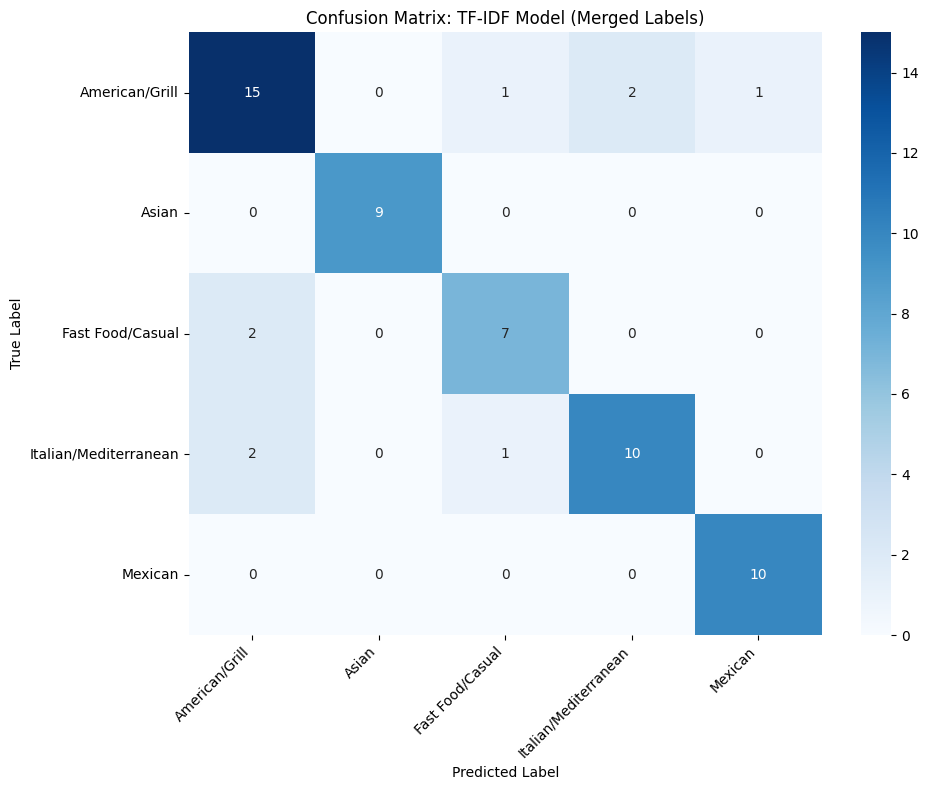

In [12]:
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 7. CONFUSION MATRIX (TF-IDF Model)
# ==========================================
print("\nGenerating Confusion Matrix for TF-IDF...")

# Get unique class labels sorted to match the matrix
labels = sorted(df_grouped['merged_label'].unique())

# Compute matrix
cm = confusion_matrix(y_test, y_pred_tfidf, labels=labels)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: TF-IDF Model (Merged Labels)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



Generating Comparison Report...

--- MODEL COMPARISON SUMMARY ---
Metric  Macro F1  Weighted F1
Model                        
BERT       0.895        0.882
TF-IDF     0.864        0.849
------------------------------


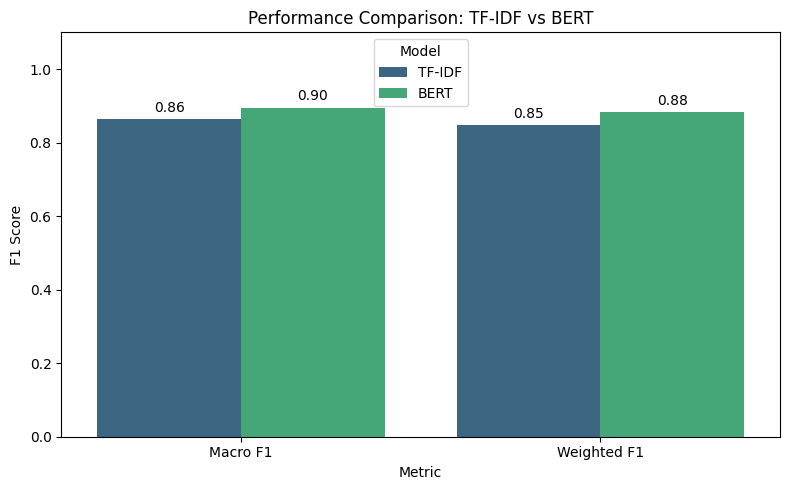

In [13]:
# ==========================================
# 8. COMPARISON: TF-IDF vs BERT (Table & Plot)
# ==========================================
print("\nGenerating Comparison Report...")

# Calculate F1 Scores explicitly
scores_data = {
    'Model': ['TF-IDF', 'TF-IDF', 'BERT', 'BERT'],
    'Metric': ['Macro F1', 'Weighted F1', 'Macro F1', 'Weighted F1'],
    'Score': [
        f1_score(y_test, y_pred_tfidf, average='macro'),
        f1_score(y_test, y_pred_tfidf, average='weighted'),
        f1_score(y_test, y_pred_bert, average='macro'),
        f1_score(y_test, y_pred_bert, average='weighted')
    ]
}

# Create DataFrame
df_comparison = pd.DataFrame(scores_data)

# 1. Print Small Table for Report
print("\n--- MODEL COMPARISON SUMMARY ---")
print(df_comparison.pivot(index='Model', columns='Metric', values='Score').round(3))
print("-" * 30)

# 2. Plot Bar Chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_comparison, x='Metric', y='Score', hue='Model', palette="viridis")

# Add numbers on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title('Performance Comparison: TF-IDF vs BERT')
plt.ylim(0, 1.1)  # Set y-axis to max 1.1 so labels fit
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()

# Final: Comparison and Performance Analysis beween 1st version and 4th version 

1. Executive Summary
The most significant improvement in this project came from Data Engineering (Label Merging) rather than model selection alone. While the 1st version of TF-IDF model was initially more robust to the fragmented data, the BERT model (4th version) became the superior classifier once the labels were consolidated into broader semantic categories.
	Best Configuration: BERT + Merged Labels
	Final Accuracy: 88%
	Final Macro F1: 0.90

2. Impact of Label Merging (Data Strategy)
The original dataset contained 19 specific cuisine types, many of which had extremely low support (1-3 samples). This caused significant "class fragmentation," where models could not distinguish between semantically identical labels (e.g., Hamburger vs. Fast Food).
	Before Merging: The BERT model (1st version) struggled significantly (Accuracy: 0.67), failing to generalize on classes with only 1 training example.
	After Merging: By grouping similar cuisines (e.g., American, Grill, 
Steak   →American/Grill), the performance for BERT (4th version) jumped by +21% Accuracy and +29% Macro F1. This confirms that for deep learning models like BERT, adequate support per class is more critical than granular label specificity.

3. Model Comparison: TF-IDF vs. BERT
Metric	TF-IDF (Merged)	BERT (Merged)	Winner
Accuracy	0.85	0.88	BERT (+3%)
Macro F1	0.86	0.90	BERT (+4%)
Weighted F1	0.85	0.88	BERT (+3%)
	Why TF-IDF was robust initially: In the early experiments with 19 classes, TF-IDF outperformed BERT (0.83 vs 0.67). TF-IDF relies on exact keyword matching (e.g., seeing the word "tacos" immediately signals "Mexican"), which works well even with little data.
	Why BERT won eventually: Once the classes were merged to provide sufficient data (approx. 10-15 samples per group), BERT's ability to understand context allowed it to outperform TF-IDF. For example, in the difficult Fast Food/Casual category, BERT achieved an F1-score of 0.89, significantly beating TF-IDF's 0.78. BERT could likely distinguish "quick service" context better than just spotting keywords.
    
4. Error Analysis (Confusion Matrix)
Looking at the Confusion Matrix for the TF-IDF model, we can identify specific patterns of error:
	Perfect Categories: Both models achieved 100% precision and recall for Asian and Mexican cuisines. The vocabulary for these (e.g., "sushi", "curry", "salsa") is highly distinct and rarely overlaps with other categories.
	The "American" Confusion: The majority of errors occurred between American/Grill and Fast Food/Casual.
	Example: The model misclassified 2 "Fast Food" restaurants as "American/Grill".
	Reason: Both categories share high-frequency words like "burger," "fries," and "chicken." While BERT handled this nuance better than TF-IDF, the overlap remains the primary challenge for the classifier.
	Italian/Mediterranean: There was minor confusion where Italian places were predicted as American. This likely happens with generic reviews (e.g., "Great service and good food") that lack specific dish names like "pasta."
5. Conclusion & Recommendation
We recommend deploying the BERT model with Merged Labels. It offers the highest reliability across all categories, specifically improving performance on the hardest classes (Fast Food and American) where the TF-IDF baseline falls short.
